In [1]:
%matplotlib inline

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pandas as pd
import contextily as ctx
from mplcairo import operator_t
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patheffects
import cartopy.crs as ccrs
import numpy as np
from math import floor
import matplotlib.patches as mpatches
import subprocess
from lib.funcs import *
from lib.mapping import *
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

mpl.rc('font', family='DejaVu Sans')

In [3]:
recorte_maior = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_maior.shp')
recorte_menor = gpd.read_file('./data/BASES/limite_recorte/limite_recorte_menor.shp')
limite_mun = gpd.read_file('./data/BASES/limite_municipio/limite_municipio.shp')
lotes_empreendimentos = gpd.read_file('./data/BASES/empreendimento/empreendimento.shp')
populacao_bairros = gpd.read_file('./data/POPULACAO/bairros.shp')
populacao_setores = gpd.read_file('./data/POPULACAO/setores_recorte.shp')

limite_mun = gpd.read_file("./data/BASES/limite_municipio/limite_municipio.shp")

recorte_maior = recorte_maior.to_crs(epsg=3857)
recorte_menor = recorte_menor.to_crs(epsg=3857)
limite_mun = limite_mun.to_crs(epsg=3857)
populacao_setores = populacao_setores.to_crs(epsg=3857)
populacao_bairros = populacao_bairros.to_crs(epsg=3857)
lotes_empreendimentos = lotes_empreendimentos.to_crs(epsg=3857)

bairros_recorte_maior_list = ['Torre', 'Tambauzinho', 'Expedicionários', 'Miramar', 'Pedro Gondim', 'Estados']
bairros_recorte_menor_list = ['Torre', 'Tambauzinho', 'Expedicionários', 'Miramar']

bairros_recorte_maior = populacao_bairros.loc[populacao_bairros['NM_BAIRRO'].isin(bairros_recorte_maior_list)]
bairros_recorte_maior = bairros_recorte_maior.reindex([21, 46, 40, 53, 22, 56])
bairros_recorte_maior['coords'] = bairros_recorte_maior['geometry'].apply(lambda x: x.centroid.coords[:])
bairros_recorte_maior['coords'] = [coords[0] for coords in bairros_recorte_maior['coords']]
bairros_recorte_maior['geometry'] = bairros_recorte_maior['geometry'].buffer(0.001)
bairros_recorte_menor = bairros_recorte_maior.loc[bairros_recorte_maior['NM_BAIRRO'].isin(bairros_recorte_menor_list)]

In [88]:
def anotate_bairros(ax, plt, bairros_recorte):
    count = 0
    legend_dict = {}
    full_string = ''
    for idx, row in bairros_recorte.iterrows():
        count += 1
        legend_dict[row['NM_BAIRRO']] = str(count)+':'+row['NM_BAIRRO']
        ax.text(row.coords[0], 
                row.coords[1], 
                s=str(count), 
                horizontalalignment='center', 
                bbox={'facecolor': 'none', 'alpha':0.8, 'edgecolor':'none'})

        full_string+= '{0}: {1} \n'.format(count, row['NM_BAIRRO'])
        
    plt.annotate(full_string, (.82, .775), xycoords='figure fraction')

In [89]:
def plot_categorical(df,
                     column,
                     k,
                     alpha,
                     borders,
                     lotes_empreendimentos,
                     bairros_recorte,
                     output,
                     annotation_pos_1,
                     annotation_pos_2,
                     annotation_pos_3,
                     zoom,
                     legend_title,
                     scale_extension=1,
                     factor_top=1,
                     factor_right=1,
                     factor_bottom=1,
                     factor_left=1,
                     legend_y = 0.07):

    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams["figure.figsize"] = (15,15)
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.bottom'] = False
    plt.style.use('ggplot')
    plt.rcParams['figure.facecolor'] = '#ffffff'
    plt.rcParams['figure.edgecolor'] = 'red'
    mpl.rcParams['legend.facecolor'] = '#ffffff'
    mpl.rcParams['figure.edgecolor'] = 'black'
    mpl.rcParams['legend.loc'] = 'lower center'


    fig = plt.figure(figsize = (15,15))
    gs1 = gridspec.GridSpec(2, 1, height_ratios=[10, 0.5])
    gs1.update(wspace=0.01, hspace=0.01)
    ax = plt.subplot(gs1[0], projection = ccrs.epsg(3857))
    cax = plt.subplot(gs1[1])
    plt.subplots_adjust(wspace=0, hspace=0)
    ax.set_facecolor('none')
    ax.set_axis_off()


    plot = df.plot(ax=ax,
                   column=column,
                   cmap='viridis_r',
                   linewidth=1,
                   scheme='quantiles',
                   k=k,
                   edgecolor='#FFFFFF',
                   alpha=alpha,
                   zorder=1)

    crop(ax, factor_top, factor_right, factor_bottom, factor_left)

    cmap = mpl.cm.viridis.reversed()
    divider = make_axes_locatable(ax)


    bins = get_bins(df, column, k=k)

    norm = mpl.colors.BoundaryNorm(bins, cmap.N)

    for i, border in enumerate(borders):
            border_plot = border.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=(0.6+(i+1/2)), linestyle='--')

    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerBackground, zoom=zoom, alpha = 0.2, attribution="", zorder=0)



    legend_elements = []
    legend_elements = [Line2D([0], [0], color='#2BBDCC', lw=2, label='Novos Empreendimentos', linestyle='--'),
                       Line2D([0], [0], color='#000000', lw=2, label='Área Foco', linestyle='--')]

    # Create the figure
    ax.legend(handles=legend_elements, loc='lower left')

    scale = scale_bar(ax, ccrs.epsg(3857), scale_extension)


    plt.annotate('Fonte: IBGE - Censo 2010', (0,0), (600, 95), xycoords='axes fraction', textcoords='offset points', va='center')
    plt.annotate('Base Cartográfica por Stamen Design', (0,0), (600, 80), xycoords='axes fraction', textcoords='offset points', va='center')

    #cax = divider.append_axes("bottom", size="5%", pad=0.05)
    #plt.tight_layout(pad=0)

    cb = mpl.colorbar.ColorbarBase(ax=cax,
                                   cmap=cmap,
                                   norm=norm,
                                   spacing='uniform',
                                   orientation='horizontal',
                                   extend='neither',
                                   ticks=bins,
                                   drawedges=True,
                                   alpha=alpha)
    cb.outline.set_edgecolor('#ffffff')
    cb.dividers.set_linewidth(3)

    bairros_recorte.plot(ax=ax, 
                         facecolor='none', 
                         edgecolor='black',
                         linewidth=0.6,
                         column='NM_BAIRRO')

    anotate_bairros(ax, plt, bairros_recorte)

    
    pos1 = cax.get_position() # get the original position
    pos2 = [pos1.x0 +0.004, pos1.y0 + legend_y,  pos1.width, pos1.height]
    cax.set_position(pos2) # set a new position
    cax.tick_params(colors="none")
    plt.setp(cax.get_xticklabels(), color="black")

    plt.annotate(legend_title, (0,0), annotation_pos_3, xycoords='axes fraction', textcoords='offset points', va='center')

    empreendimentos_plot = lotes_empreendimentos.plot(ax=ax,
                                                      facecolor='none',
                                                      edgecolor='tab:cyan',
                                                      linewidth=(2.5),
                                                      linestyle='--',
                                                      zorder=5)
    #operator_t.MULTIPLY.patch_artist(plot)
    #operator_t.SOURCE.patch_artist(empreendimentos_plot)

    
    
    
    plt.savefig('OUTPUT' + output+'.pdf')
    plt.savefig('OUTPUT' + output+'.png')

    

    plt.show()

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2d9ca46b80> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


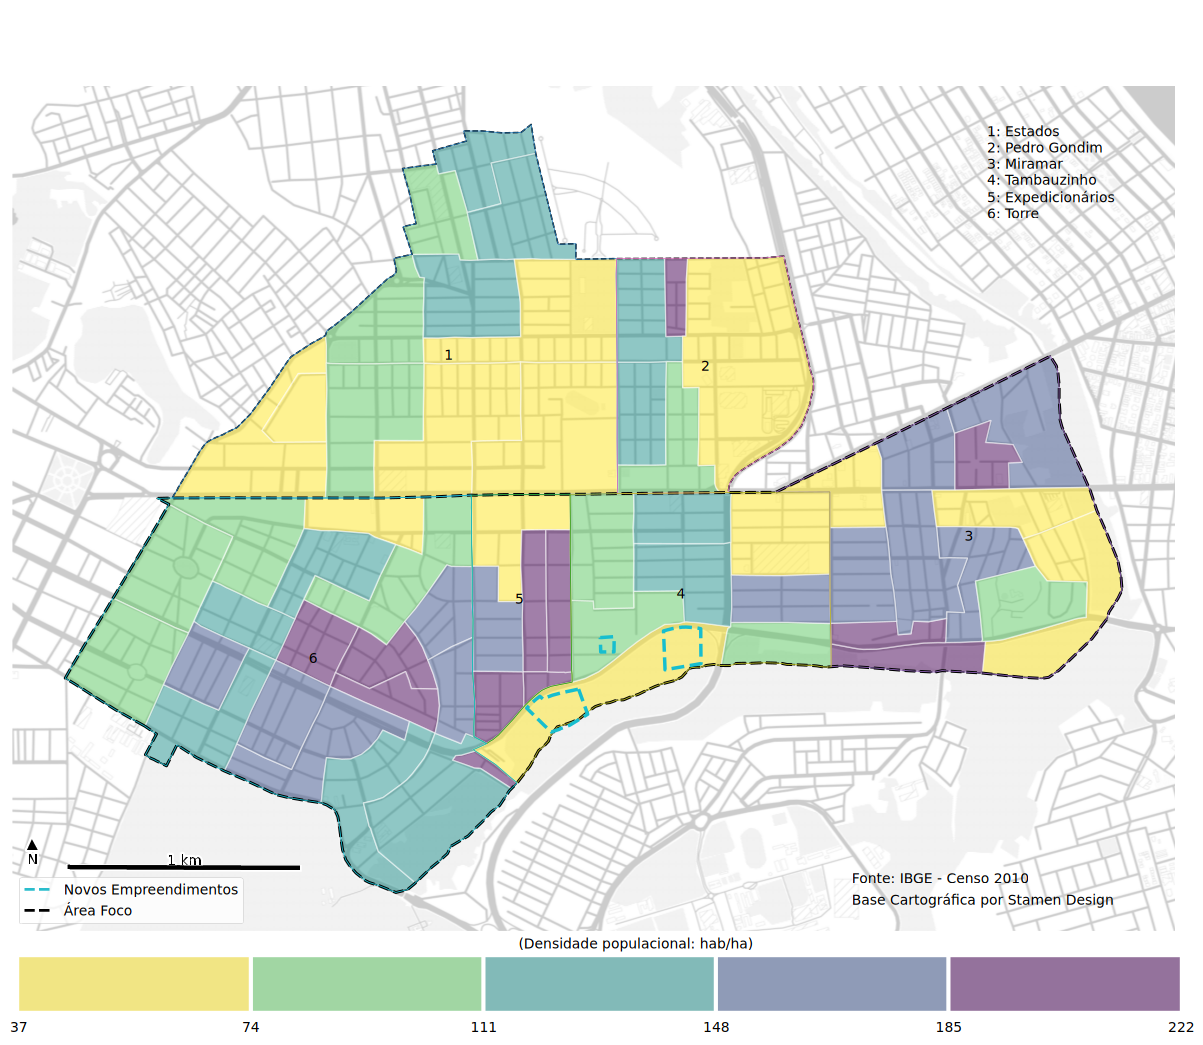

In [90]:
borders = [recorte_maior, recorte_menor]
plot_categorical(populacao_setores, 
                 'densidade',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor], 
                 lotes_empreendimentos,
                 'densidade_populacional_recorte', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 16, 
                 '(Densidade populacional: hab/ha)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1,
                 factor_top=1)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2d9cb33950> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


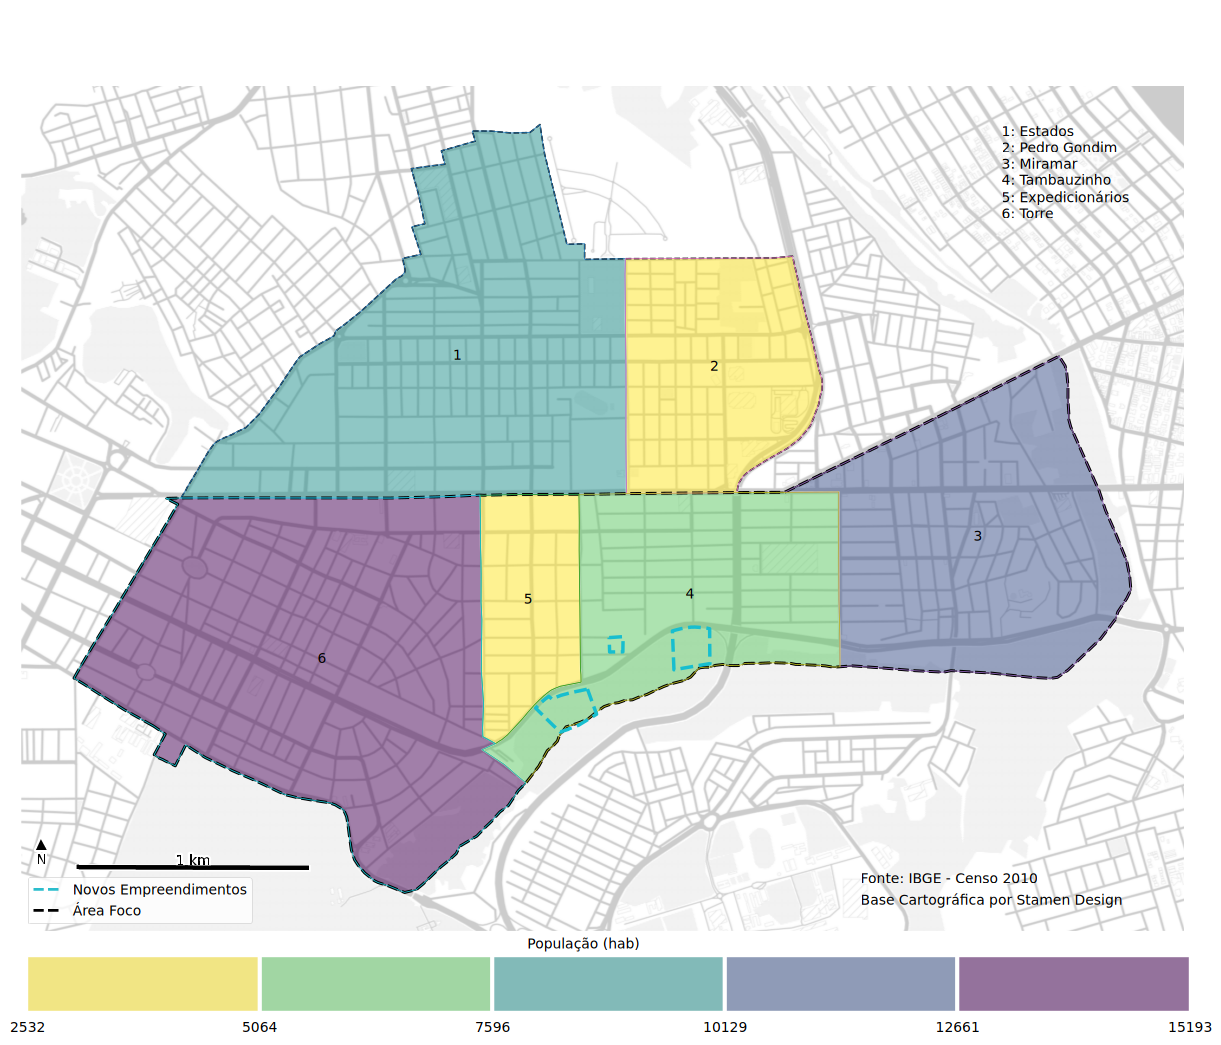

In [91]:
plot_categorical(bairros_recorte, 
                 'MORADORES',
                 5,
                 0.5,
                 [recorte_maior, recorte_menor],
                 lotes_empreendimentos,
                 'populacao_recorte', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 16, 
                 'População (hab)',
                 legend_y = 0.07,
                 scale_extension=1,
                 factor_left=1,
                 factor_right=1,
                 factor_bottom=1,
                 factor_top=1)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2d9cb8f130> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


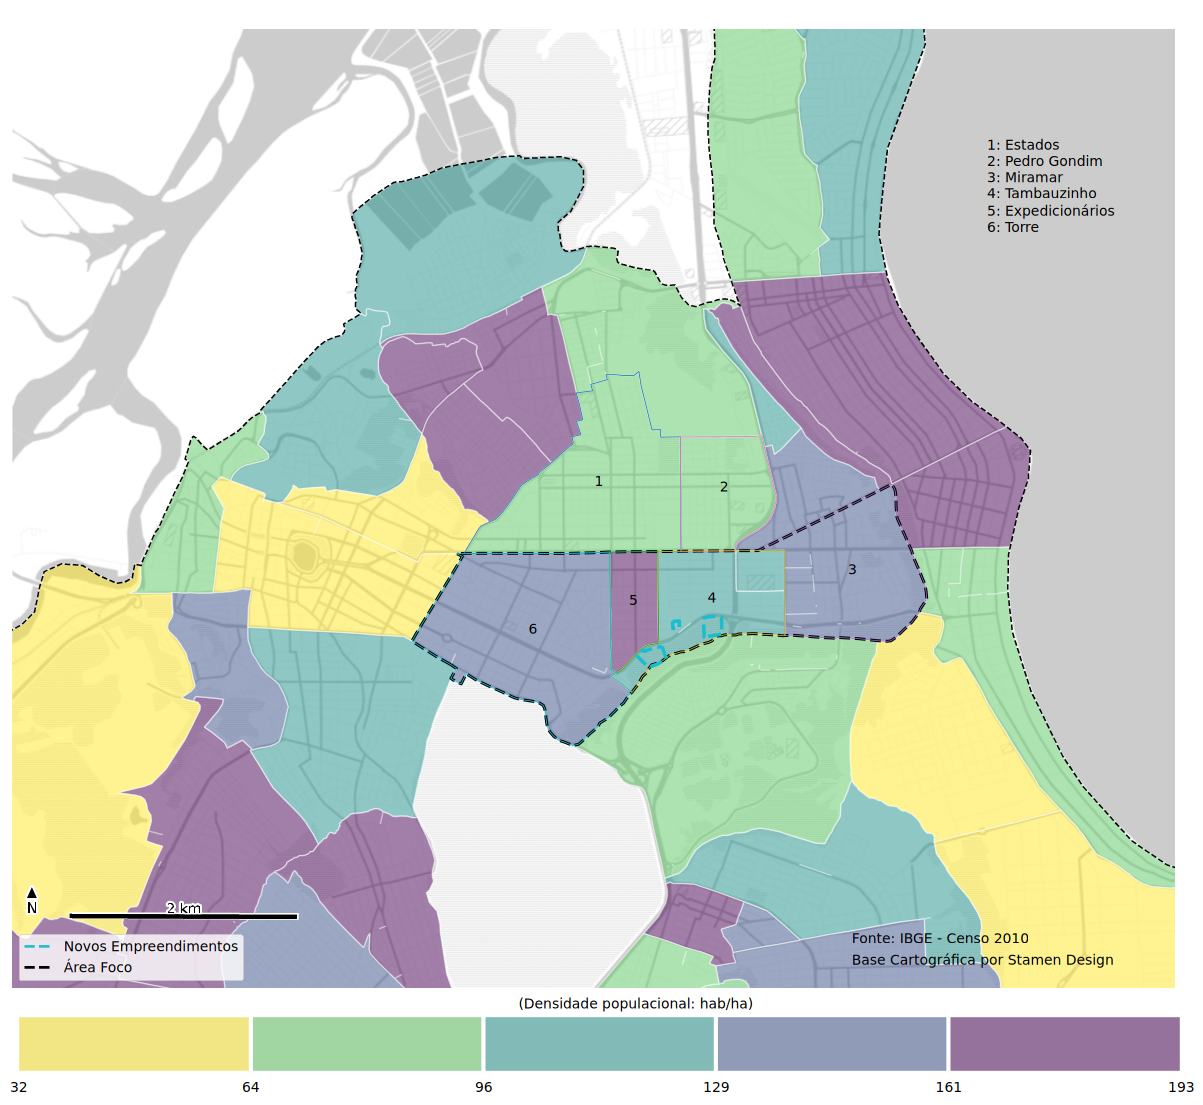

In [92]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor], 
                 lotes_empreendimentos,
                 'densidade_populacional_centro', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 14, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 factor_top=0.7)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2db39b5270> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


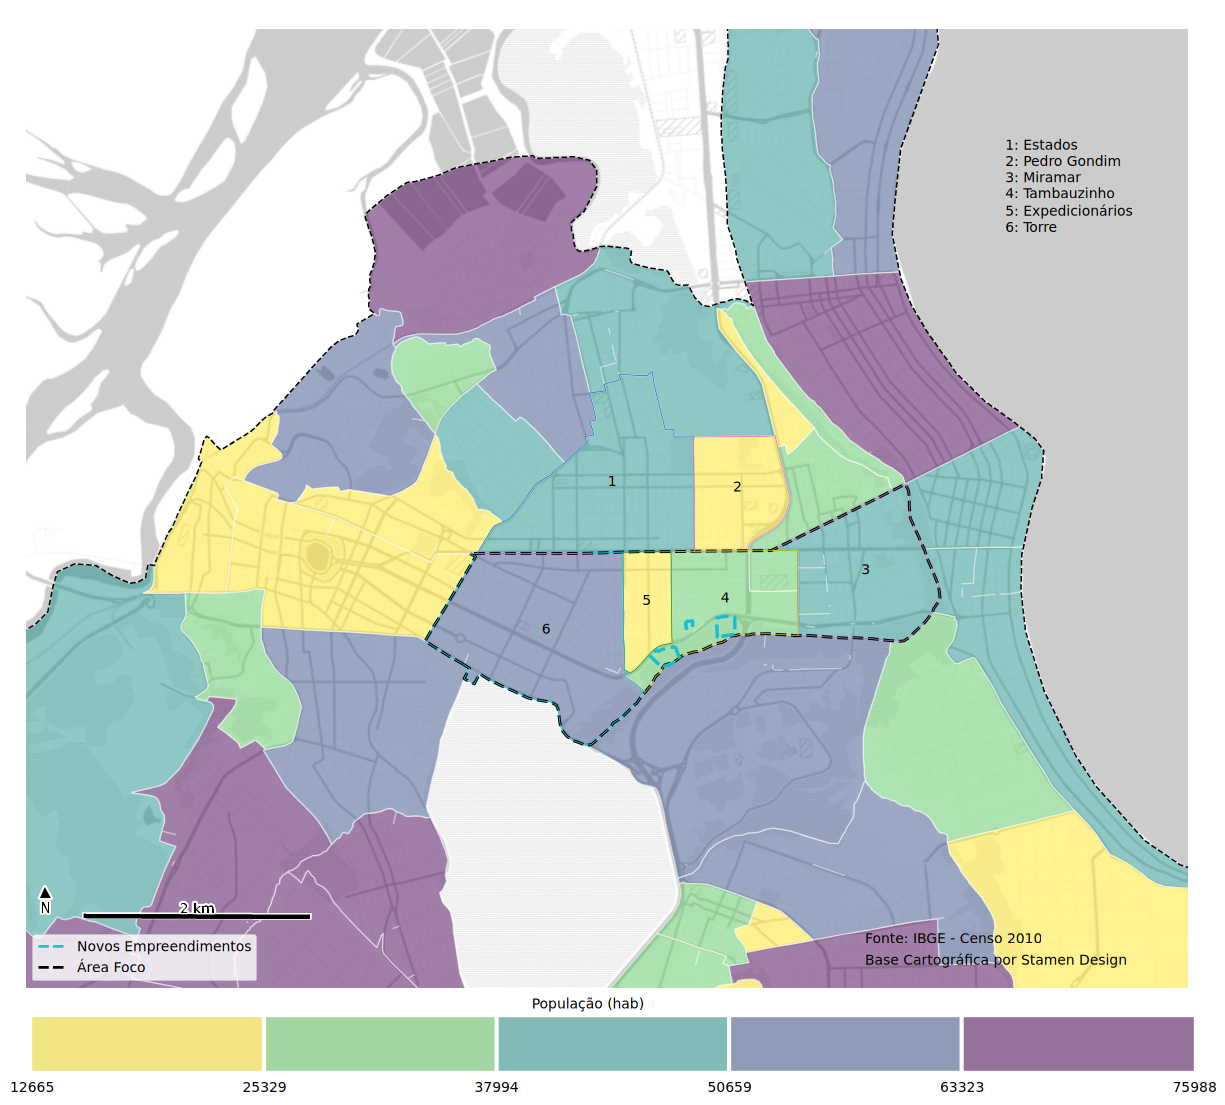

In [93]:
plot_categorical(populacao_bairros, 
                 'MORADORES',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 'populacao_centro', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 14, 
                 'População (hab)', 
                 scale_extension=2,
                 legend_y = 0.03,
                 factor_left=0.5,
                 factor_right=0.7,
                 factor_bottom=0.05,
                 factor_top=0.7)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2d9a39dc20> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


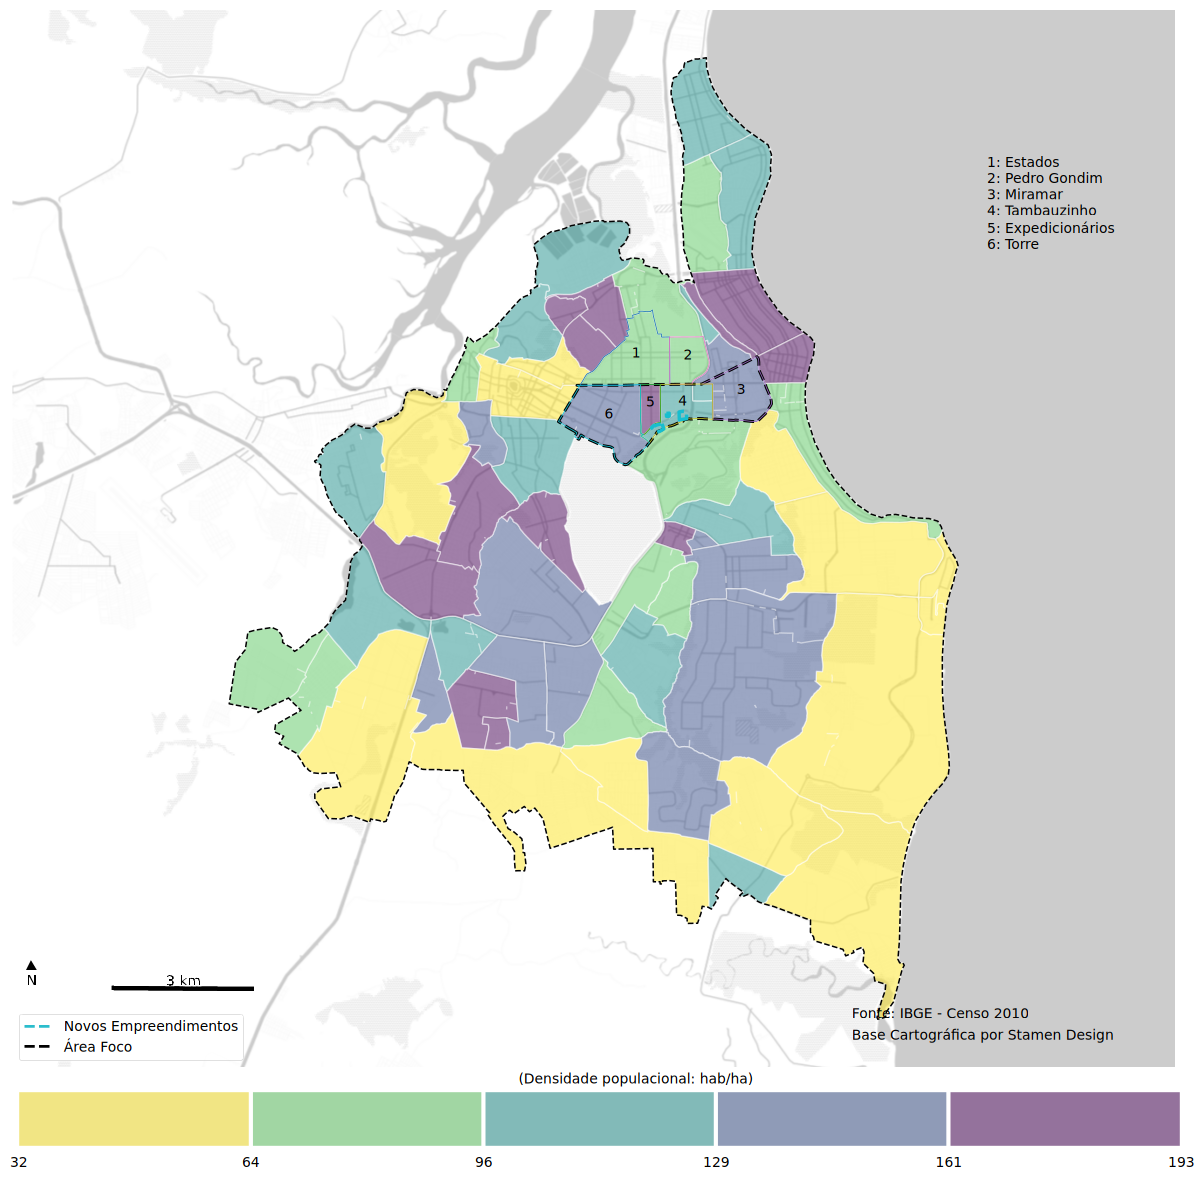

In [94]:
plot_categorical(populacao_bairros, 
                 'densidade',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 'densidade_populacional_cidade', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 13, 
                 '(Densidade populacional: hab/ha)', 
                 scale_extension=3,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1,
                 factor_top=1)

/home/fc-anjos/.local/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f2d9a3430e0> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


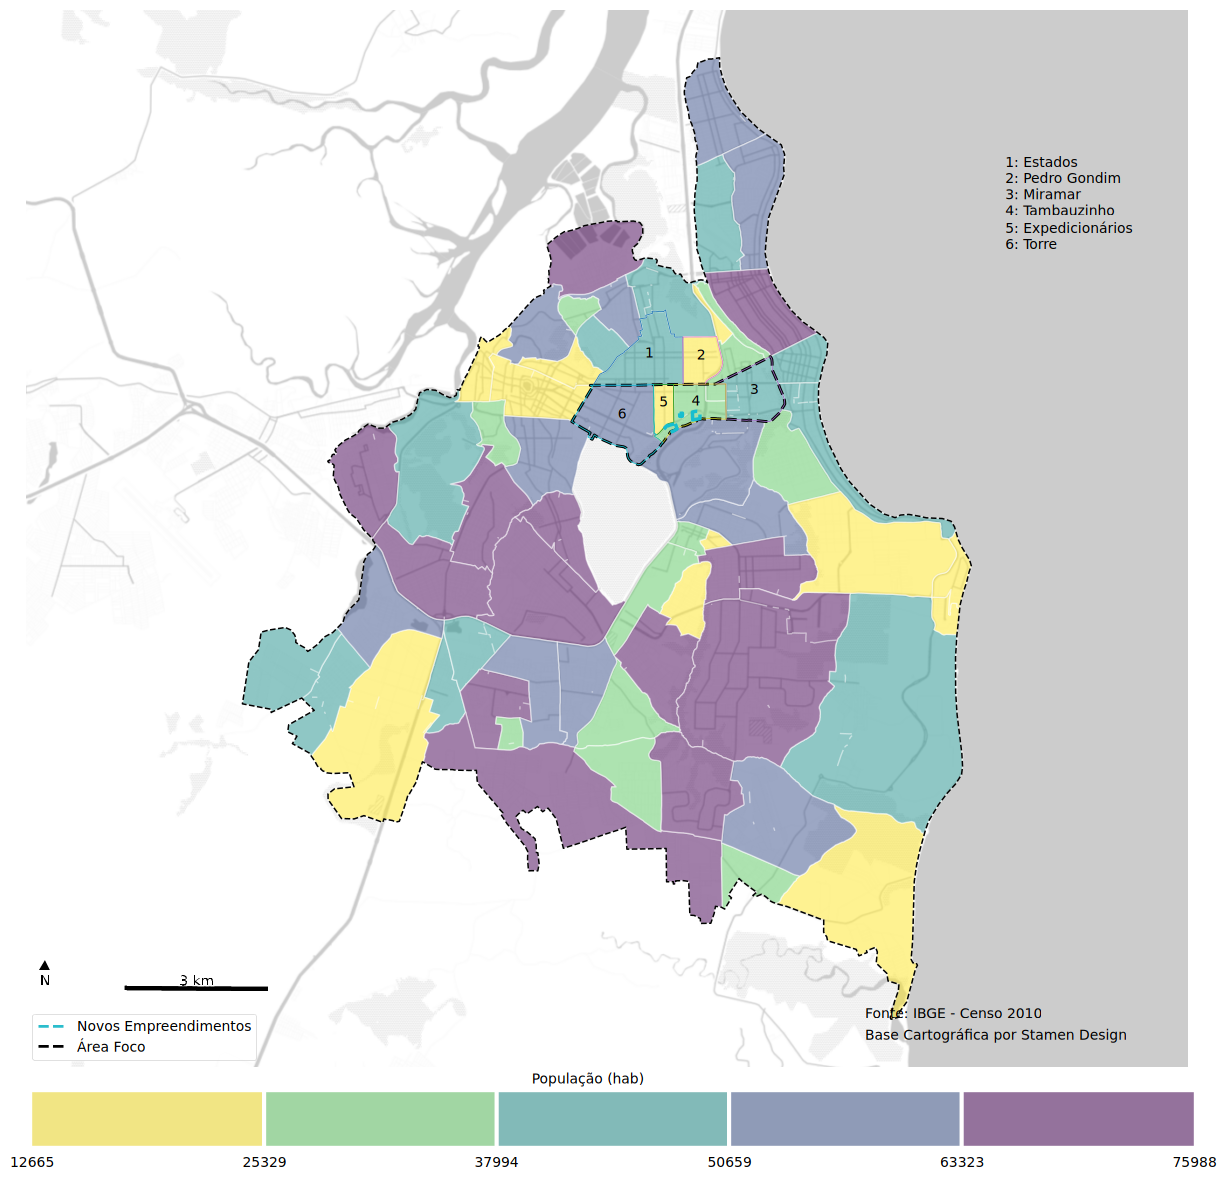

In [95]:
plot_categorical(populacao_bairros, 
                 'MORADORES',
                 5,
                 0.5,
                 [limite_mun, recorte_menor],
                 lotes_empreendimentos,
                 'populacao_cidade', 
                 (600, 95), 
                 (600, 80), 
                 (360, 48),
                 13, 
                 'População (hab)', 
                 scale_extension=3,
                 legend_y = 0,
                 factor_left=1.45,
                 factor_right=1.45,
                 factor_bottom=1,
                 factor_top=1)